<a href="https://colab.research.google.com/github/Maram00ali/REV4RE/blob/main/CNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 13.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [ ]:
dataset = pd.read_csv('dataset path')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84932 entries, 0 to 84931
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review          84932 non-null  object
 1   RivewRelevance  84932 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
# take a peek at the data
dataset.head()

,Review,RivewRelevance
0,5 star good app,1
1,A monthly subscription fee. Really?,1
2,Able to customize and decorate a ton of things...,1
3,All I can say is this game is the best!!,1
4,"Although not the best, it better for own creat...",1


### Prepare Train Test Split

In [ ]:
# Importing NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

In [ ]:
def preprocess_text(main_df):
  df_1 = main_df.copy()

  # remove stopwords
  nltk.download('stopwords')         # Downloading stopwords
  stop = stopwords.words('english')
  df_1['Review'] = df_1['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # remove punctuations and convert to lower case
  #df_1['Review'] = df_1['Review'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))

  # remove double spaces
  #df_1['Review'] = df_1['Review'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1

In [ ]:
dataset = preprocess_text(dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset

,Review,RivewRelevance
0,5 star good app,1
1,A monthly subscription fee. Really?,1
2,Able customize decorate ton things even free! ...,1
3,All I say game best!!,1
4,"Although best, better creatives.",1
...,...,...
84927,Your app sucks.Im deleting it.I know I'm getti...,1
84928,Your app wait along process downloads west dat...,1
84929,Your customer service unresponsive. I email go...,1
84930,Your new desktop version sucks. I save send in...,1


In [ ]:
# build train and test datasets
reviews = dataset['Review'].values
relevences = dataset['RivewRelevance'].values

train_reviews = reviews[:67945]
train_relevences = relevences[:67945]

test_reviews = reviews[16987:]
test_relevences = relevences[16987:]

# Text Wrangling & Normalization

In [ ]:
#import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
%%time

norm_train_reviews = train_reviews
norm_test_reviews = test_reviews

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('glenwood', 40192), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=40193
Number of Documents=67945


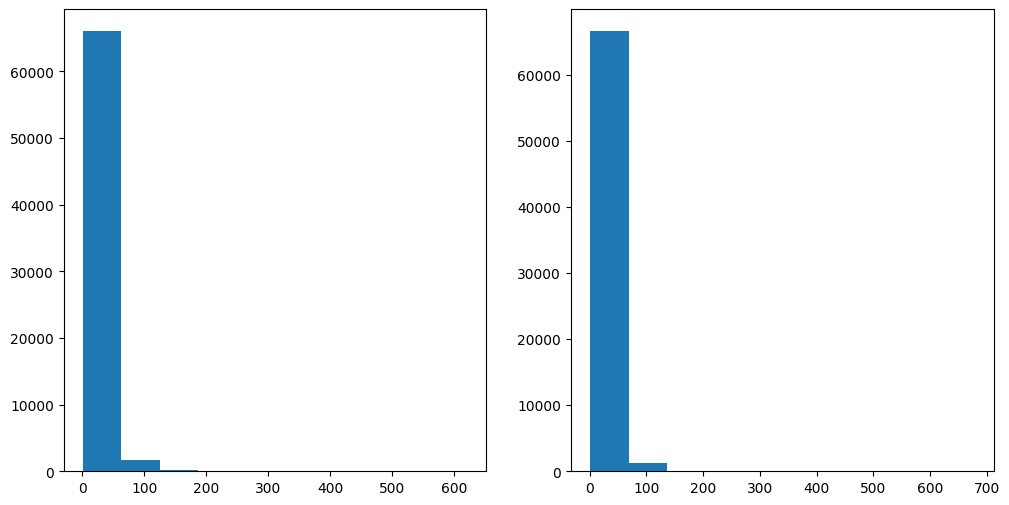

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((67945, 1000), (67945, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
le = LabelEncoder()
num_classes=3 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_relevences)
y_test = le.transform(test_relevences)

In [ ]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [ ]:
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=32

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         12057900  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

## Model Training

In [ ]:
# Fit the model
model.fit(X_train, y_train,
          validation_split=0.20,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/100
1699/1699 [==============================] - 109s 57ms/step - loss: -309503590400.0000 - accuracy: 0.8115 - val_loss: -727662067712.0000 - val_accuracy: 0.7962
Epoch 2/100
1699/1699 [==============================] - 43s 25ms/step - loss: -24141348470784.0000 - accuracy: 0.8159 - val_loss: -25294889025536.0000 - val_accuracy: 0.7934
Epoch 3/100
1699/1699 [==============================] - 40s 23ms/step - loss: -247792953982976.0000 - accuracy: 0.8161 - val_loss: -178946792488960.0000 - val_accuracy: 0.7964
Epoch 4/100
1699/1699 [==============================] - 39s 23ms/step - loss: -1139463413563392.0000 - accuracy: 0.8168 - val_loss: -673602873589760.0000 - val_accuracy: 0.7979
Epoch 5/100
1699/1699 [==============================] - 38s 22ms/step - loss: -3499407819407360.0000 - accuracy: 0.8168 - val_loss: -1820731528708096.0000 - val_accuracy: 0.7971
Epoch 6/100
1699/1699 [==============================] - 39s 23ms/step - loss: -8535465279881216.0000 - accuracy: 0.816

## Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2124/2124 [==============================] - 14s 7ms/step - loss: -15615097926701004357632.0000 - accuracy: 0.8516
Accuracy: 85.16%


In [ ]:
predictions = model.predict(X_test).round()
predictions[:10]

2124/2124 [==============================] - 11s 5ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
predictions
#= [1 if item == '1' else 0 if item== 0 else 2 if item=2 for item in predictions]
predictions[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
test_relevences

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
predictions

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
#CNN
labels = ['Relevent', 'Irrelevant','Mixed_class']
print(classification_report(test_relevences, predictions))
pd.DataFrame(confusion_matrix(test_relevences, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.28      0.19      0.22      4867
           1       0.88      0.96      0.92     59278
           2       0.00      0.00      0.00      3800

    accuracy                           0.85     67945
   macro avg       0.39      0.38      0.38     67945
weighted avg       0.79      0.85      0.82     67945



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Relevent,Irrelevant,Mixed_class
Relevent,919,3948,0
Irrelevant,2334,56944,0
Mixed_class,71,3729,0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=378be7ce-053e-4e53-a8d7-d43f011c835b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>